# Feature Engineering

In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

## Carga de datos

Se cargan las columnas con formatos adecuados según el tipo de datos.  
Se usa como índice building_id para train_values y train_labels  
La lista columnas NO tiene a building_id

In [2]:
# Train values
# Levantar los datos de cada edificio/casa
df = pd.read_csv('datos/train_values.csv',nrows=0)
columnas = df.columns.to_list()
datatypes = {
    **{columnas[0]:np.int32}\
    , **{column:np.int16 for column in columnas[1:8] + columnas[27:28]}\
    , **{column:'category' for column in columnas[8:15] + columnas[26:27]}\
    , **{column:np.bool for column in columnas[15:26] + columnas[28:39]}
}
train_values = pd.read_csv('datos/train_values.csv',dtype=datatypes)
train_values = train_values.set_index("building_id")
columnas = train_values.columns.to_list()

In [3]:
#Train labels
train_labels = pd.read_csv('datos/train_labels.csv',index_col='building_id')

## Información de los datasets

In [4]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          260601 non-null  int16   
 1   geo_level_2_id                          260601 non-null  int16   
 2   geo_level_3_id                          260601 non-null  int16   
 3   count_floors_pre_eq                     260601 non-null  int16   
 4   age                                     260601 non-null  int16   
 5   area_percentage                         260601 non-null  int16   
 6   height_percentage                       260601 non-null  int16   
 7   land_surface_condition                  260601 non-null  category
 8   foundation_type                         260601 non-null  category
 9   roof_type                               260601 non-null  category
 10  ground_floor_type          

In [5]:
train_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
28830,8,900,2812,2,10,8,7,o,r,n,...,False,False,False,False,False,False,False,False,False,False
94947,21,363,8973,2,10,5,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
590882,22,418,10694,2,10,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
201944,11,131,1488,3,30,8,9,t,r,n,...,False,False,False,False,False,False,False,False,False,False


In [6]:
train_labels.head()

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


## Recorte de features

Utilicemos Random Forest para ver la importancia de los features  
Importamos lo necesario para correr Random Forest

In [7]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

# Para ver los parametros que se utilizan
from pprint import pprint
import pickle

In [8]:
## Se obtiene de correr con RF todos los features originales
filename = 'all_features_rf_n150_minleaf3.sav'

In [9]:
loaded_model = pickle.load(open(filename, 'rb'))

In [10]:
feature_importance = loaded_model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
sorted_idx = feature_importance.argsort()
len(feature_importance)

68

El modelo se entreno con todos los features y get_dummies

In [11]:
train_values_subset = pd.get_dummies(train_values)

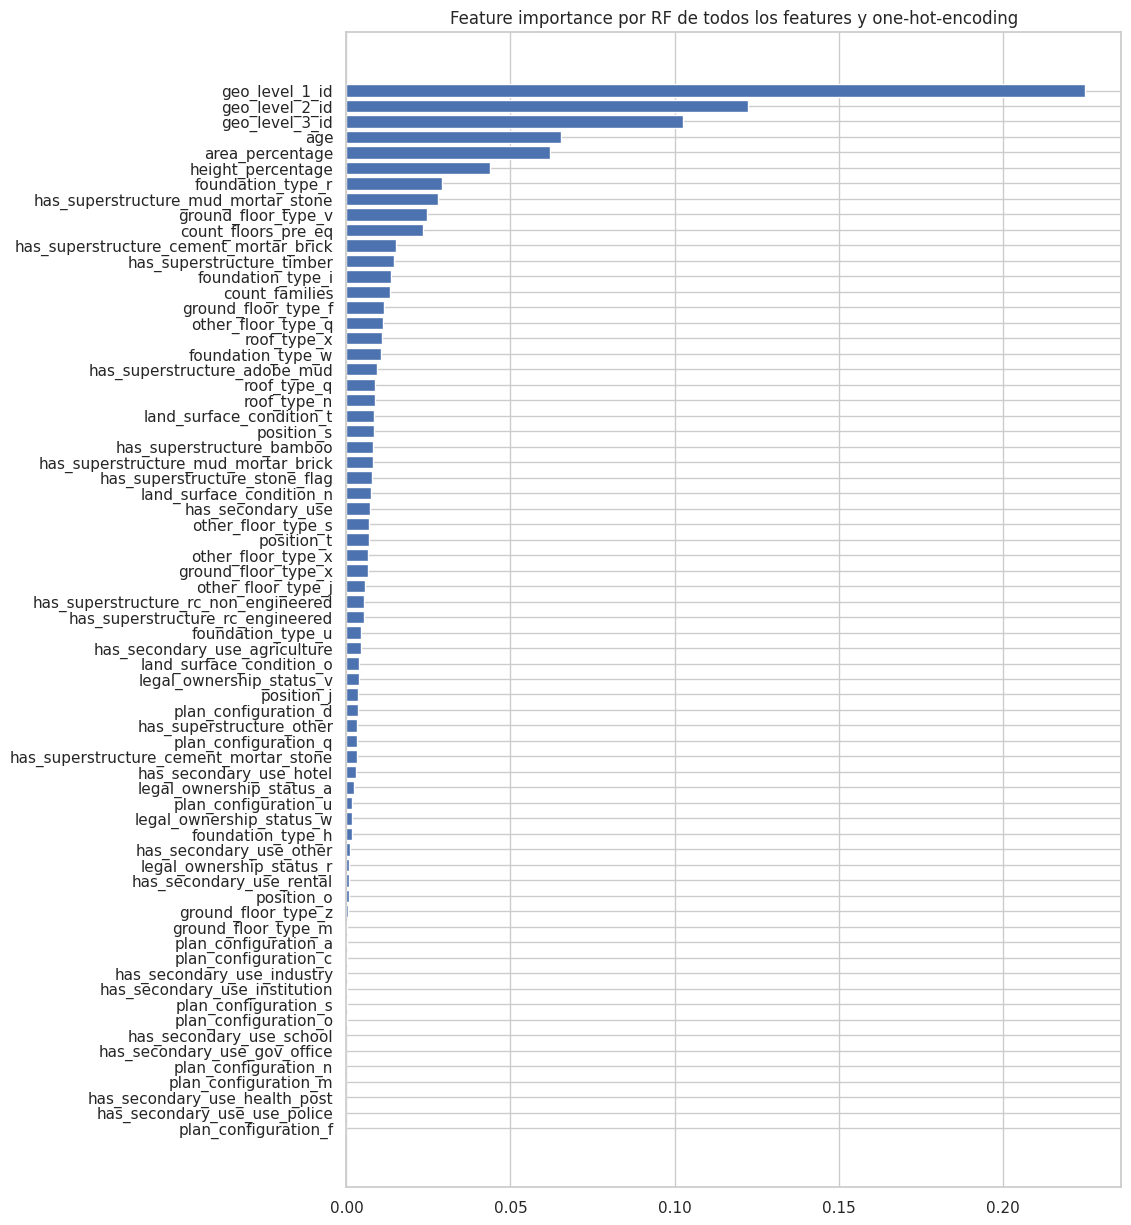

In [12]:
#Grafico de feature importance
fig, ax = plt.subplots(figsize=(10,15))
ax.barh(train_values_subset.columns[sorted_idx],feature_importance[sorted_idx])
ax.set_title('Feature importance por RF de todos los features y one-hot-encoding')
plt.show()

Usando XGBOOST

In [13]:
#Se obtiene de correr con XGBoost todos los features y max depth 10
filename = 'all_features_xgb_md10.sav'

In [14]:
loaded_model = pickle.load(open(filename, 'rb'))

In [15]:
feature_important = loaded_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)

El modelo se entreno con todos los features y get_dummies

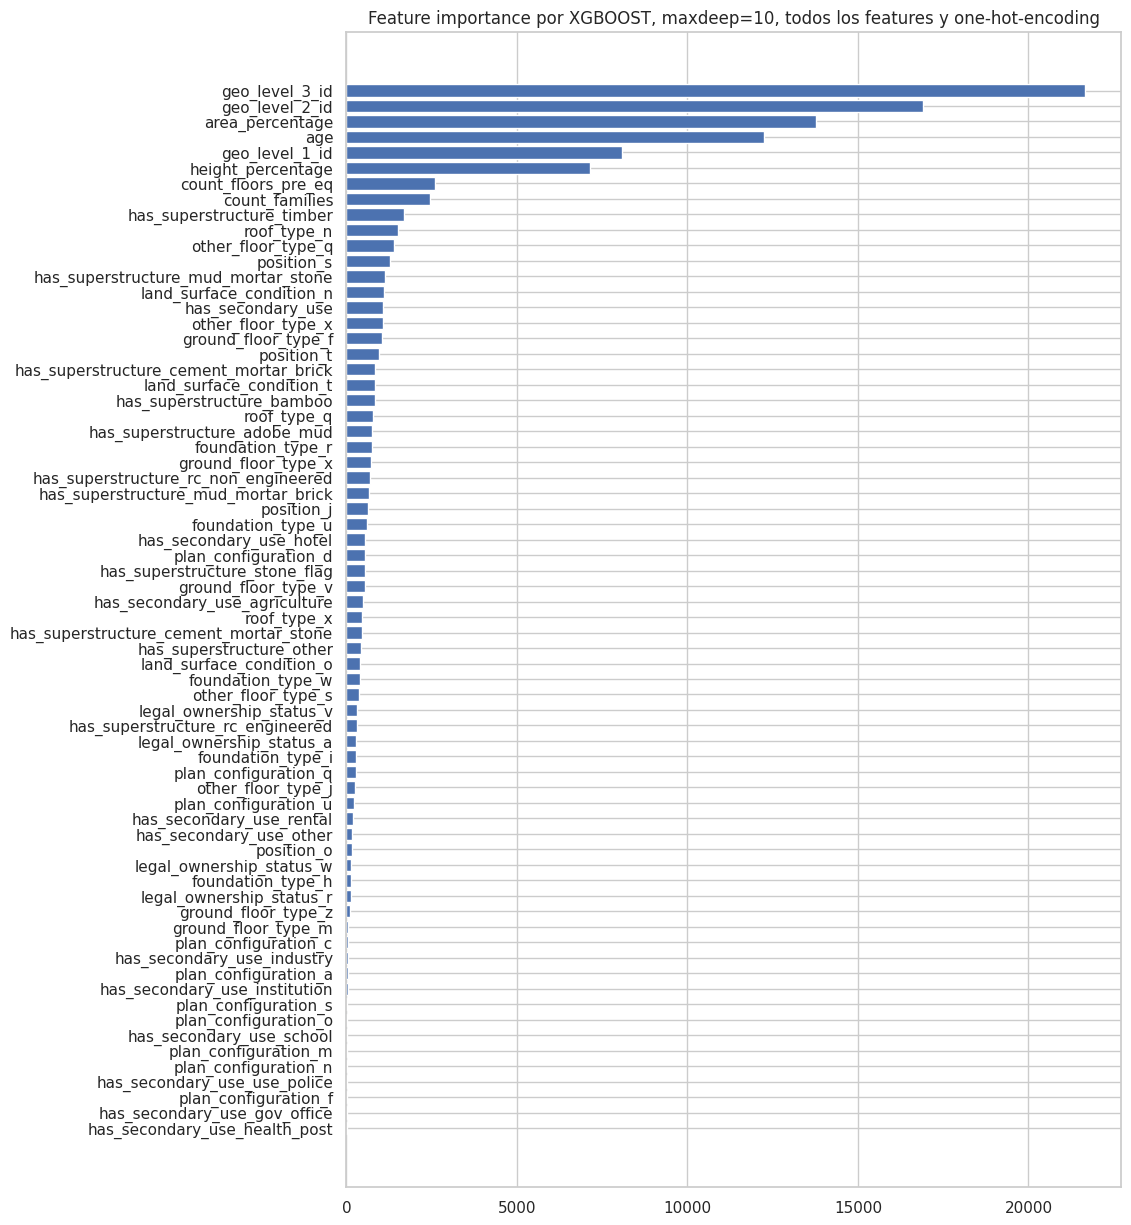

In [16]:
#Grafico de feature importance
fig, ax = plt.subplots(figsize=(10,15))
ax.barh(data.index,data['score'].values)
ax.set_title('Feature importance por XGBOOST, maxdeep=10, todos los features y one-hot-encoding')
plt.show()